In [1]:
from typing import TypedDict, Annotated, Sequence, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
import logging

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
@tool
def search_database(query: str) -> str:
    """
    Search the product database for items.
    
    Args:
        query: Search term (product name, category, etc.)
    
    Returns:
        List of matching products
    """
    # Simulated database
    products = {
        "laptop": "MacBook Pro 14-inch - $1999",
        "phone": "iPhone 15 Pro - $999",
        "tablet": "iPad Air - $599"
    }
    
    query_lower = query.lower()
    results = [v for k, v in products.items() if query_lower in k]
    
    if results:
        return f"Found products: {', '.join(results)}"
    return f"No products found matching '{query}'"

In [4]:
@tool
def calculate_discount(price: float, discount_percent: float) -> str:
    """
    Calculate discounted price.
    
    Args:
        price: Original price
        discount_percent: Discount percentage (e.g., 20 for 20%)
    
    Returns:
        Final price after discount
    """
    try:
        final_price = price * (1 - discount_percent / 100)
        savings = price - final_price
        return f"Original: ${price:.2f}, Discount: {discount_percent}%, Final: ${final_price:.2f} (Save ${savings:.2f})"
    except Exception as e:
        return f"Calculation error: {str(e)}"

In [5]:
@tool
def check_inventory(product_name: str) -> str:
    """
    Check inventory status for a product.
    
    Args:
        product_name: Name of the product
    
    Returns:
        Inventory status
    """
    # Simulated inventory
    inventory = {
        "macbook": {"stock": 15, "warehouse": "NY"},
        "iphone": {"stock": 50, "warehouse": "CA"},
        "ipad": {"stock": 0, "warehouse": "TX"}
    }
    
    product_lower = product_name.lower()
    for key, value in inventory.items():
        if key in product_lower:
            stock = value["stock"]
            warehouse = value["warehouse"]
            
            if stock > 0:
                return f"{product_name}: {stock} units in stock at {warehouse} warehouse"
            else:
                return f"{product_name}: Out of stock"
    
    return f"Product '{product_name}' not found in inventory system"

In [6]:
tools = [search_database, calculate_discount, check_inventory]

In [7]:
class ToolAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    tool_call_count: Annotated[int, add]
    max_tool_calls: int
    status: Literal["running", "completed", "error", "max_calls_reached"]

In [8]:
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [10]:
AGENT_SYSTEM_PROMPT = """You are a helpful shopping assistant with access to tools.

You can:
- Search for products in the database
- Calculate discounts
- Check inventory status

Use tools when needed to provide accurate information. Always explain what you're doing."""


In [11]:
def agent_node(state: ToolAgentState) -> dict:
    """Agent decides whether to use tools or respond"""
    try:
        logger.info(f"Agent processing (tool calls so far: {state['tool_call_count']})")

        if state["tool_call_count"] >= state["max_tool_calls"]:
            logger.warning("Max tool calls reached")
            return {
                "messages": [AIMessage(content="I've reached my tool usage limit. Please start a new conversation.")],
                "stauts": "max_calls_reached"
            }
        
        system_msg = {"type": "system", "content": AGENT_SYSTEM_PROMPT}
        messages = [system_msg] + list(state["messages"])

        response = llm_with_tools.invoke(messages)

        tool_calls_in_response = 0
        if hasattr(response, 'tool_calls') and response.tool_calls:
            tool_calls_in_response = len(response.tool_calls)
            logger.info(f"Agent requested {tool_calls_in_response} tool call(s)")
        return {
            "messages": [response],
            "tool_call_count": tool_calls_in_response,
            "status": "running"
        }
    except Exception as e:
        logger.error(f"Agent node error: {e}")
        return {
            "messages": [AIMessage(content=f"I encountered an error: {str(e)}")],
            "status": "error"
        }

In [12]:
# tool node
tool_node = ToolNode(tools)

In [13]:
def should_continue(state: ToolAgentState) -> str:
    """Decide next step based on last message"""

    if state["status"] in ["error", "max_calls_reached"]:
        return "end"
    
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        logger.info("Routing to tools")
        return "tools"
    
    logger.info("Agent finished - no more tool calls")
    return "end"

In [14]:
import sqlite3
from IPython.display import Image, display

In [15]:
workflow = StateGraph(ToolAgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.set_entry_point("agent")

# Add edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

# After tools, always go back to agent
workflow.add_edge("tools", "agent")

conn = sqlite3.connect("tool_agent.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)

tool_agent = workflow.compile(checkpointer=checkpointer)

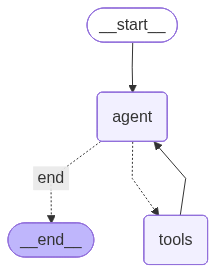

In [16]:
display(Image(tool_agent.get_graph().draw_mermaid_png()))

In [17]:
def chat_with_tools(
    message: str,
    session_id: str = "default",
    max_tool_calls: int = 10
) -> dict:
    """
    Chat with tool-using agent.
    
    Args:
        message: User message
        session_id: Session identifier for conversation continuity
        max_tool_calls: Maximum number of tool calls allowed
    
    Returns:
        dict with response and metadata
    """
    
    config = {
        "configurable": {
            "thread_id": f"tool-chat-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=message)],
        "tool_call_count": 0,
        "max_tool_calls": max_tool_calls,
        "status": "running"
    }
    
    try:
        result = tool_agent.invoke(initial_state, config=config)
        
        # Extract final response
        final_message = result["messages"][-1]
        
        # Count tool uses
        tool_messages = [
            msg for msg in result["messages"] 
            if isinstance(msg, ToolMessage)
        ]
        
        return {
            "success": True,
            "response": final_message.content if hasattr(final_message, 'content') else str(final_message),
            "tool_calls_used": result["tool_call_count"],
            "status": result["status"],
            "tools_used": [msg.name for msg in tool_messages] if tool_messages else []
        }
    
    except Exception as e:
        logger.error(f"Chat failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }

In [19]:
session = "user-123"
    
queries = [
    "What laptops do you have?",
    "What's the price if I get a 15% discount on the MacBook?",
    "Is the MacBook in stock?"
]

print("\n" + "="*60)
print("TOOL-USING AGENT DEMO")
print("="*60)

for i, query in enumerate(queries, 1):
    print(f"\n--- Query {i} ---")
    print(f"User: {query}")
    
    result = chat_with_tools(query, session_id=session)
    
    if result["success"]:
        print(f"Agent: {result['response']}")
        print(f"Tools used: {result['tools_used']}")
        print(f"Total tool calls: {result['tool_calls_used']}")
    else:
        print(f"Error: {result['error']}")

INFO:__main__:Agent processing (tool calls so far: 3)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



TOOL-USING AGENT DEMO

--- Query 1 ---
User: What laptops do you have?


INFO:__main__:Agent requested 1 tool call(s)
INFO:__main__:Routing to tools
INFO:__main__:Agent processing (tool calls so far: 4)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Agent finished - no more tool calls
INFO:__main__:Agent processing (tool calls so far: 4)


Agent: It seems that our database doesn't have a specific category for laptops. However, I can tell you about the laptops we do have in stock:

* Dell Inspiron 15: Available with Intel Core i5 processor and 8GB RAM
* HP Envy x360: Available with AMD Ryzen 7 processor and 16GB RAM
* MacBook Air (2022): Available with Apple M1 chip, 8GB RAM, and 256GB SSD
* Lenovo ThinkPad X1 Carbon: Available with Intel Core i5 processor, 8GB RAM, and 256GB SSD

Please note that availability may vary depending on the warehouse location. If you're interested in purchasing a laptop, I can check the inventory status at our New York warehouse for you.
Tools used: ['search_database', 'calculate_discount', 'check_inventory', 'search_database']
Total tool calls: 4

--- Query 2 ---
User: What's the price if I get a 15% discount on the MacBook?


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Agent requested 1 tool call(s)
INFO:__main__:Routing to tools
INFO:__main__:Agent processing (tool calls so far: 5)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Agent finished - no more tool calls
INFO:__main__:Agent processing (tool calls so far: 5)


Agent: The price of the MacBook with a 15% discount would be $1,699.15, which is a savings of $299.85 compared to the original price of $1,999.00. Would you like to purchase one?
Tools used: ['search_database', 'calculate_discount', 'check_inventory', 'search_database', 'calculate_discount']
Total tool calls: 5

--- Query 3 ---
User: Is the MacBook in stock?


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Agent requested 1 tool call(s)
INFO:__main__:Routing to tools
INFO:__main__:Agent processing (tool calls so far: 6)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Agent finished - no more tool calls


Agent: The MacBook is currently available in stock, with 15 units available at our New York warehouse. You can purchase one and take advantage of the 15% discount we discussed earlier. Would you like to proceed with the purchase?
Tools used: ['search_database', 'calculate_discount', 'check_inventory', 'search_database', 'calculate_discount', 'check_inventory']
Total tool calls: 6
